# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
#NOTE - had to save given .xlsx file as .xls (excel 97-2003) and change extension below
#df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers = pd.read_excel("./WineKMC.xls", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
#NOTE - see cell 2 for comment
#df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions = pd.read_excel("./WineKMC.xls", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
#Did not see need to do merge for this exercise and, seeing tier 1, really did not do anything
#to fulfill request.  However, in case it comes up later, here is merge as in tier 1:
merged = pd.merge(df_transactions, df_offers)

df_trans_pivot = pd.pivot_table(df_transactions, index=['customer_name'], values='n',
                   columns=['offer_id']).fillna(0).add_prefix('offer_id_')
#Get rid of "offer_id" in top left corner
df_trans_pivot.columns.name = ""
df_trans_pivot.reset_index(inplace=True)
df_trans_pivot.head()

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

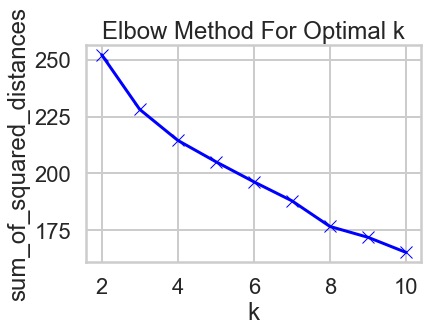

In [6]:
#your turn
#MY TIER 3 VERSION
def get_kmeans_list(X, k_range, rand_state):
    from sklearn.cluster import KMeans
    km_list = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=rand_state)
        km = km.fit(X)
        km_list.append(km)
    return km_list
def get_sum_of_squared_dist_list(km_list):
    sum_of_squared_dist_list = []
    for km in km_list:
        sum_of_squared_dist_list.append(km.inertia_)
    return sum_of_squared_dist_list
  
    
x_cols = df_trans_pivot.drop(columns=['customer_name']).to_numpy()
k_low = 2
k_high = 10
k_range = range(k_low, k_high + 1)
KM_list = get_kmeans_list(x_cols, k_range, rand_state=0)
SS_list = get_sum_of_squared_dist_list(KM_list)

plt.plot(k_range, SS_list, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


BEST K GUESS:  Based on this plot, there is no clear "Elbow".  The 2 to 3 k drop and 3 to 4 k drop are large enough to eliminate k = 2 or 3.  However, the further drops are rather even.  A pick of 4, 5 or even 6 could be a reasonable elbow.  
Thus, the best guess would seem to be 5.

Text(0, 0.5, 'Sum of Squares')

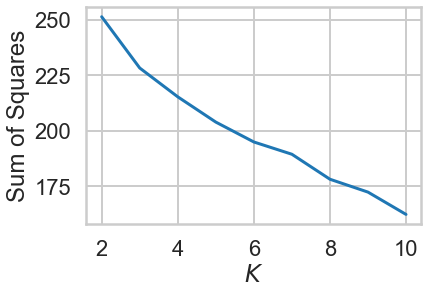

In [7]:
# your turn

#THIS IS EXERCISE AS ABOVE DONE VIA TIER 1 METHOD - NOTE IT RESULTS IN THE SAME PLOT
#Have since found out that, in some situations, this way may be preferred when
#it is desired to have some control on calculating using sum of squares variations
import sklearn.cluster
import numpy as np

# Make an empty list
ss = []

# Make an empty dictionary called assignments 
assignments = {}

# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
X = pivoted.to_numpy()

#X = df_trans_pivot.drop(columns=['customer_name']).to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
    
# Call plot() on plt with parameters Krange and ss
plt.plot(Krange, ss)

# Let's label the plot 
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

# Can you see what we're doing here? 

5


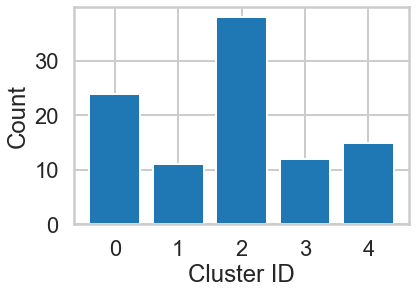

In [8]:
#FROM TIER 1
# What is the best K? Fill in the assignment below appropriately
best_K = 5
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
plt.bar(range(best_K), counts, align = 'center')

# Label the axes 
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(range(best_K))
plt.show()

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

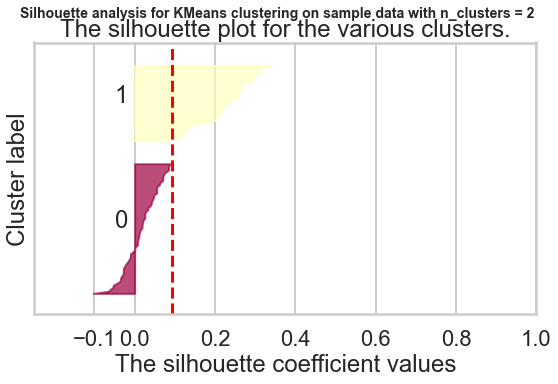

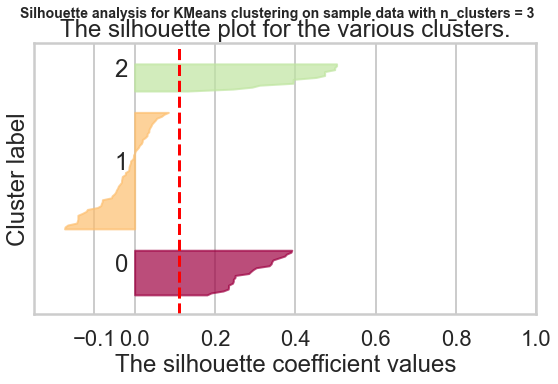

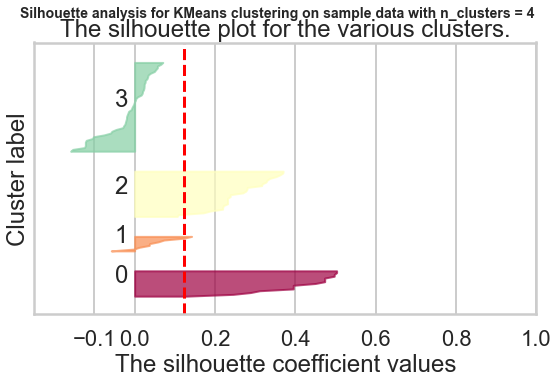

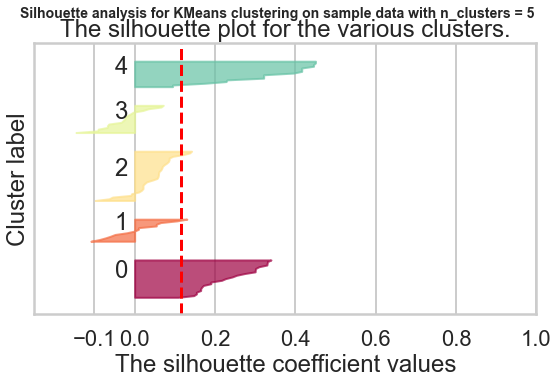

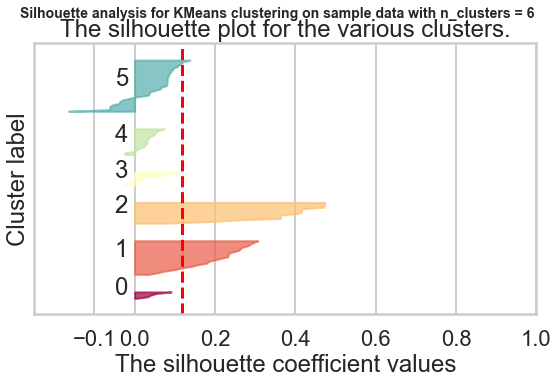

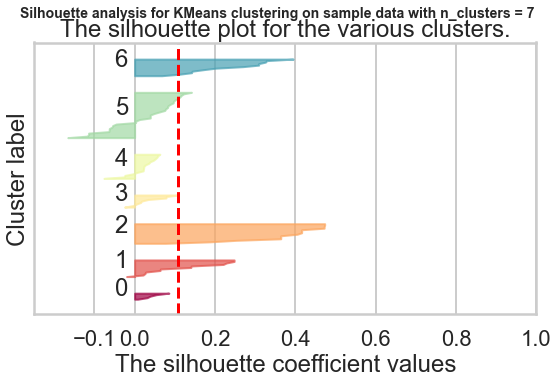

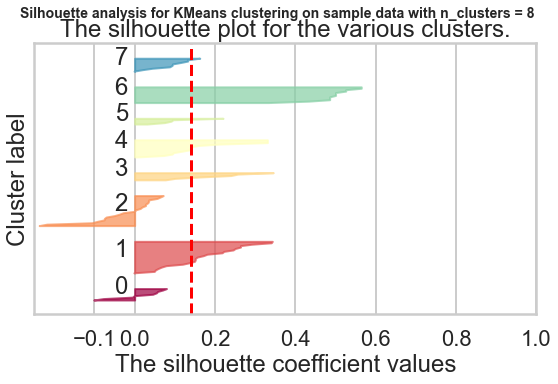

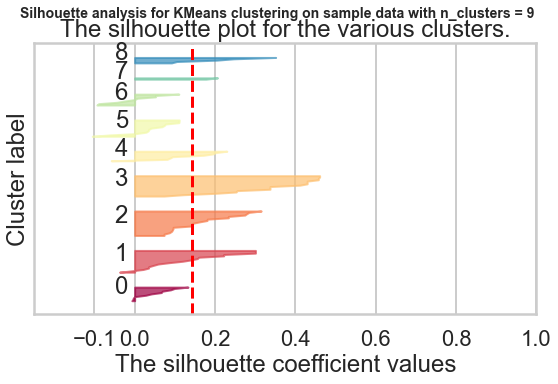

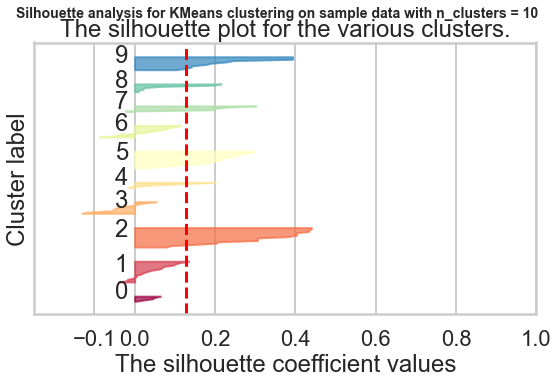

In [9]:
#FROM TIER 1
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.metrics
import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Average Silhouette Score')

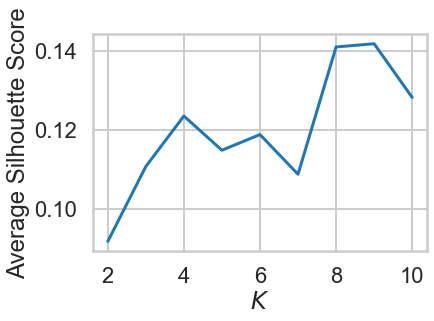

In [10]:
#FROM TIER 1
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")

CONCLUSION:  By looking at all the silhouette plots, the best K value isn't automatically clear because no graph has every cluster passing the average line. Also, all but one individual cluster structure is weak or worse (under 0.5 coefficient). Thus, there are no strong candidates.  However, trying to take the best of the bunch when visually trying to take into account having a good proportion of clusters passing the average line, along with minimizing outlier/misclassifications (below 0 line) and having a relatively even thickness among the plots, n_clusters 8, 9 and 10 are all interesting.  However, n_cluster = 9 appears to most embody all these requirements.  This also matches up with the edge it has with the highest silhouette score.  This varies from the n_cluster = 5 based on the Elbow method.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? <b>(My note: see response in next cell)</b>
    
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually? <b>(My note: see response in next cell)</b>
</ul>
       
<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p> <b>(My note: see response in next cell)</b>
</div>

RESPONSES to above questions:

Q. How do the clusters look?

The clusters do not look definitive because they are close together, respecially red and green.  However, at least they don't overlap.  Perhaps other values than n_clusters=3 should be tried.  This is not shown in the notebook, but 5 and 9 were tried because those appeared to be good cluster numbers in the earlier tests.  In both cases, they had a lot of overlap between clusters.  Of course, those cluster numbers were determined without the dimensionality reduction. More number of clusters should be tested to be sure.  Since it is not part of the notebook exercise, the assumption will be that n_clusters=3 was best in this case.

Q. Based on what you see, what seems to be the best value for  𝐾 ? Moreover, which method of choosing  𝐾  seems to have produced the optimal result visually? 

The best value for K appears to be 3, with dimensionality reduction and dimensionality reduction is probably a good idea in this case. None of the methodologies produced clear cluster amounts visually, but this last one appears to have worked the best.

Q. Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

Looking at the offer ids that had the most influence on each cluster based on the graphs of "the difference between how often they were used in each cluster vs globally", here are the clusters by color, the offer ids most important and observations related to them:

    Red (offer ids 7,8,13,18,29,30): all minimum quantity 6; 0 champagne ("low-end spenders")
    
    Green (offer ids 2,8,25,27): 3 minimum quantity 72 (1 minimum quantity 6); 1 champagne ("medium spenders")
    
    Blue (offer ids 1,4,6,9,11,14,21,31): 5 minimum quantity 72, 2 minimum quantity 144, 1 minimum quantity 12; 4 champagne ("big spenders") 

In [11]:
df_offers

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


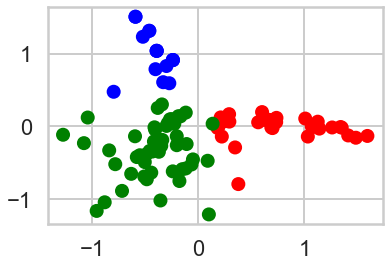

In [12]:
#your turn
#FROM TIER 1
import sklearn.decomposition
import matplotlib.colors

# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

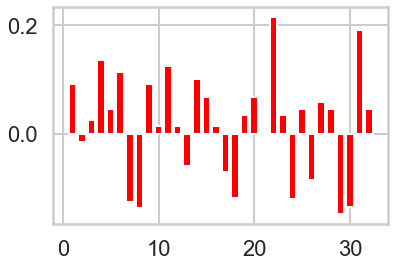

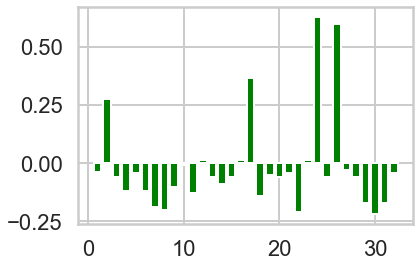

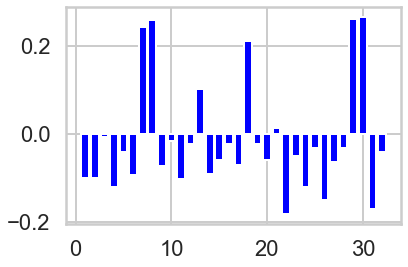

In [13]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0, 0.5, 'Proportion of Variance Explained')

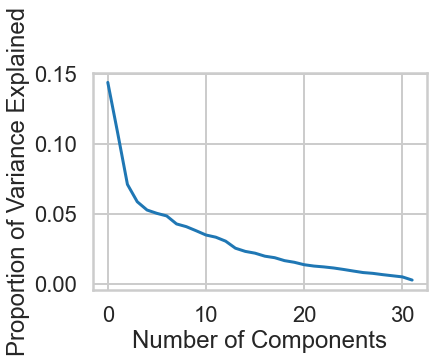

In [14]:
#FROM TIER 1
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
# Initialize a variable, called pca, and assign it sklearn.decomposition.PCA() 
pca = sklearn.decomposition.PCA()

# Call fit() on pca, with X passed to the method
pca.fit(X)

# Let's finish this :)  Make a variable called variance
variance = pca.explained_variance_ratio_

# Plot() it 
plt.plot(range(len(variance)), variance)

# Label the axes
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")

In [15]:
variance
#array([0.14386393, 0.10800289, 0.07104281, 0.05866151, 0.05273181,
#       0.05037351, 0.04853032, 0.04281792, 0.04086488, 0.03794334,
#       0.03490044, 0.03334871, 0.03051951, 0.02548482, 0.02321341,
#       0.02193338, 0.01978732, 0.01870919, 0.016607  , 0.0154309 ,
#       0.01369783, 0.01273333, 0.01213607, 0.01136126, 0.01032716,
#       0.00919489, 0.00810601, 0.00752468, 0.00660726, 0.00580346,
#       0.0050086 , 0.00273186])

array([0.14386393, 0.10800289, 0.07104281, 0.05866151, 0.05273181,
       0.05037351, 0.04853032, 0.04281792, 0.04086488, 0.03794334,
       0.03490044, 0.03334871, 0.03051951, 0.02548482, 0.02321341,
       0.02193338, 0.01978732, 0.01870919, 0.016607  , 0.0154309 ,
       0.01369783, 0.01273333, 0.01213607, 0.01136126, 0.01032716,
       0.00919489, 0.00810601, 0.00752468, 0.00660726, 0.00580346,
       0.0050086 , 0.00273186])

Exercise Set V response:  On the graph above, the Elbow looks to be at about 3 or 4.  To clarify where the drop-off significantly slows, the variance array shows that it appears to be after the fourth element, so 4 looks to be the best choice.  Therefore, the next step would be to get 4 components using PCA and create clusters via Kmeans based on those components.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

Response:
This exercise makes it apparent that getting good unsupervised clusters can take experimentation.  This includes finding the most useful number of clusters, as well as finding the best features to bring out the best clusters, sometimes, at least in part, by using PCA or some other means of reducing dimensionality.


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


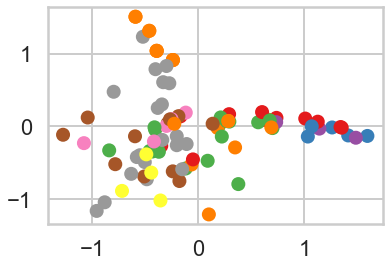

In [16]:
# Your turn
#1. Affinity propagation
from sklearn.cluster import AffinityPropagation
aff_clustering = AffinityPropagation(random_state=0).fit(X)
aff_clustering_labels = aff_clustering.labels_
plt.scatter(pc1, pc2, c=aff_clustering_labels.tolist(), cmap="Set1")

In [17]:
aff_clustering_labels

array([ 0, 10,  6,  3,  3, 12,  6,  7,  4,  2,  9, 13,  2, 12,  4,  6,  3,
        6,  0,  1,  2,  7,  4,  9,  6, 10, 11,  4, 12, 13,  3,  7,  4,  8,
        0,  5,  4,  2,  4,  5,  6,  6,  7, 12,  0,  8,  2,  3, 10, 13,  1,
       12, 13,  6,  7,  7,  6,  3,  0,  7, 12,  7, 12,  0,  0, 13,  6, 11,
        9, 10, 11, 10,  8,  3, 12,  3, 13,  3,  3, 13, 11, 10, 11, 13,  2,
        5,  0, 10, 10,  7, 12,  0,  7,  3,  1, 12,  7, 12,  8, 12],
      dtype=int64)

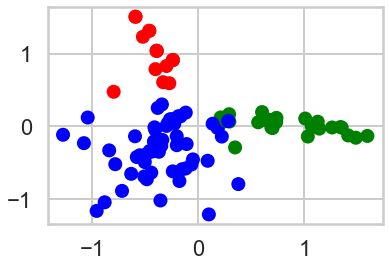

In [18]:
#2. Spectral clustering
from sklearn.cluster import SpectralClustering
spec_clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0).fit(X)
spec_clustering_labels = spec_clustering.labels_
plt.scatter(pc1, pc2, c=spec_clustering_labels.tolist(), cmap=cmap)

In [19]:
spec_clustering_labels

array([1, 2, 0, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 0,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2], dtype=int64)

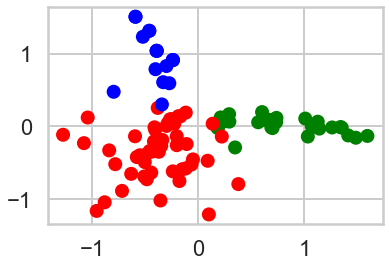

In [20]:
#3. Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
#import numpy as np
#>>> X = np.array([[1, 2], [1, 4], [1, 0], 
#...
#               [4, 2], [4, 4], [4, 0]])
agg_clustering = AgglomerativeClustering(n_clusters=3).fit(X)
#>>> clustering
#AgglomerativeClustering()
agg_clustering_labels = agg_clustering.labels_
#array([1, 1, 1, 0, 0, 0])
plt.scatter(pc1, pc2, c=agg_clustering_labels.tolist(), cmap=cmap)

In [21]:
agg_clustering_labels

array([1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 2, 0, 2, 1, 0, 1, 1,
       0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int64)

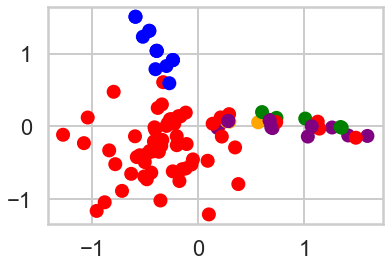

In [22]:
#4. DBSCAN
from sklearn.cluster import DBSCAN
db_clustering = DBSCAN(eps=1.41).fit(X)
db_clustering_labels = db_clustering.labels_
cmap_5color = matplotlib.colors.ListedColormap(['red', 'green', 'blue', 'purple', 'orange'])
plt.scatter(pc1, pc2, c=db_clustering_labels.tolist(), cmap=cmap_5color)

In [23]:
db_clustering_labels
#Note - -1 is noise, other values are clusters

array([ 0, -1,  1,  2, -1, -1,  1,  2, -1,  2, -1,  1,  2, -1, -1,  1, -1,
        1,  0, -1,  2,  2, -1, -1,  1, -1, -1, -1, -1, -1,  3, -1, -1, -1,
       -1, -1, -1,  2, -1, -1,  1,  1,  2, -1, -1, -1,  2, -1, -1, -1, -1,
       -1, -1,  1, -1,  2,  1,  3,  0, -1, -1,  2, -1,  0,  0, -1,  1, -1,
       -1, -1, -1, -1, -1,  3, -1,  2,  1, -1, -1,  1, -1, -1, -1,  1,  2,
       -1,  0, -1, -1,  2, -1,  0, -1,  2, -1, -1,  2, -1, -1, -1],
      dtype=int64)

Conclusion: 

First of all, it is notable that visually there are no clear clusters, so any clustering is bound to have some issues.  

The spectral and agglomerative clustering methods, in this case, appeared to perform the best.  They also did the same clusters as each other and very similar ones to k-means.

Comments on the other methods:

The affinity propogation produced a lot of clusters and they were extremely overlapping. Perhaps some parameter adjustment would help, but

The DBSCAN was tried with many different parameters for eps.  When looking at eps values up to two decimals, anything under 1 said all points were noise.  Anything between 1 and 1.41 divided things into a noise group and more than one cluster. Anything between 1.42 and 2.23 divided things into a noise group and one cluster. Anything 2.24 and above put all points into one cluster.  Note also, between 1 and 2.24, most points were put into the noise group, even though clusters were formed.
Perhaps there was not enough density spots for this method to be as useful as it can be with other data.

Overall observations:

With this data configuration where there is no clear clustering, perhaps it is helpful to have algorithms where the number of clusters is specified (kmean, spectral and agglomeration clustering) rather than not (affinity propogation and DBSCAN).

It is possible that one or more of the methods would have had different results if the PCA reduction would have been for a different number components than 2 or if all or part of the raw data was used as is.